# Homework 4 Mine

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
from treasury_cmds import *

Calculate the term spread as of the end of November 2022


In [11]:
paths_yields = 'C:/Users/dcste/OneDrive/fixed_income/fixed_income_FORKED/finm-fixedincome-2023/data/yields_2022-11-30.xlsx'
yield_df = pd.read_excel(paths_yields, sheet_name='yields').set_index('caldt')


In [13]:
yield_df['Spread'] = yield_df[10]-yield_df[1]

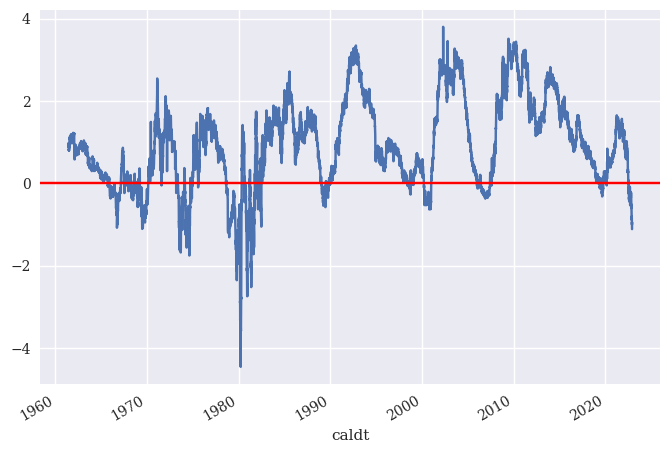

In [15]:
yield_df['Spread'].plot()
plt.axhline(0, c = 'r')

# Calcuating Forwards

- The selected treasuries are at nearly six-month intervals. Approximate that they mature at perfect 6-month intervals. We are looking at them from the perspective of March 31, 2022

- Bootstrap the discount factor. Plot the answer in terms of discount factors and discount rates

In [18]:
file_path = 'C:/Users/dcste/OneDrive/fixed_income/fixed_income_FORKED/finm-fixedincome-2023/data/selected_treasury_rates.xlsx'

forwards = pd.read_excel(file_path, sheet_name='data').set_index('KYTREASNO')

In [50]:
forwards['maturity date'] = pd.to_datetime(forwards['maturity date'])

In [56]:
QUOTE_DATE = '2022-03-31'
t_date = pd.to_datetime(QUOTE_DATE)


CF = pd.DataFrame(data=0, index=forwards.index, columns=forwards['maturity date'])

for i in forwards.index:
    coupon_dates = get_coupon_dates(t_date,pd.to_datetime(forwards.loc[i,'maturity date']))

    if coupon_dates is not None:
        CF.loc[i,coupon_dates] = forwards.loc[i,'coupon rate']/2

    CF.loc[i,forwards.loc[i,'maturity date']] += 100

CF = CF.resample('m',axis=1).sum()
CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)
CF = CF.fillna(0).sort_index(axis=1)
CF


maturity date,2022-09-30,2023-03-31,2023-09-30,2024-03-31,2024-09-30,2025-03-31,2025-09-30,2026-03-31,2026-09-30,2027-03-31,2027-09-30,2028-03-31,2028-09-30,2029-03-31
KYTREASNO,,,,,,,,,,,,,,
206896,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207688,0.0625,100.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207775,0.1250,0.1250,100.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207077,1.0625,1.0625,1.0625,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207416,0.7500,0.7500,0.7500,0.7500,100.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207507,0.2500,0.2500,0.2500,0.2500,0.2500,100.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207256,1.5000,1.5000,1.5000,1.5000,1.5000,1.5000,101.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207337,1.1250,1.1250,1.1250,1.1250,1.1250,1.1250,1.1250,101.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207777,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,0.4375,100.4375,0.0000,0.0000,0.0000,0.0000,0.0000


- Calculating the Discount placed on each issue accross time

In [64]:
COMPOUNDING = 2
spot = pd.DataFrame(np.linalg.solve(CF,forwards['price'].loc[CF.index]), index = CF.index, columns = ['Discount Factor'])
spot.insert(0,'maturity',forwards['maturity'])
spot = spot.reset_index().set_index('maturity')
spot['Rate'] = discount_to_intrate(spot['Discount Factor'], spot.index, n_compound=COMPOUNDING)

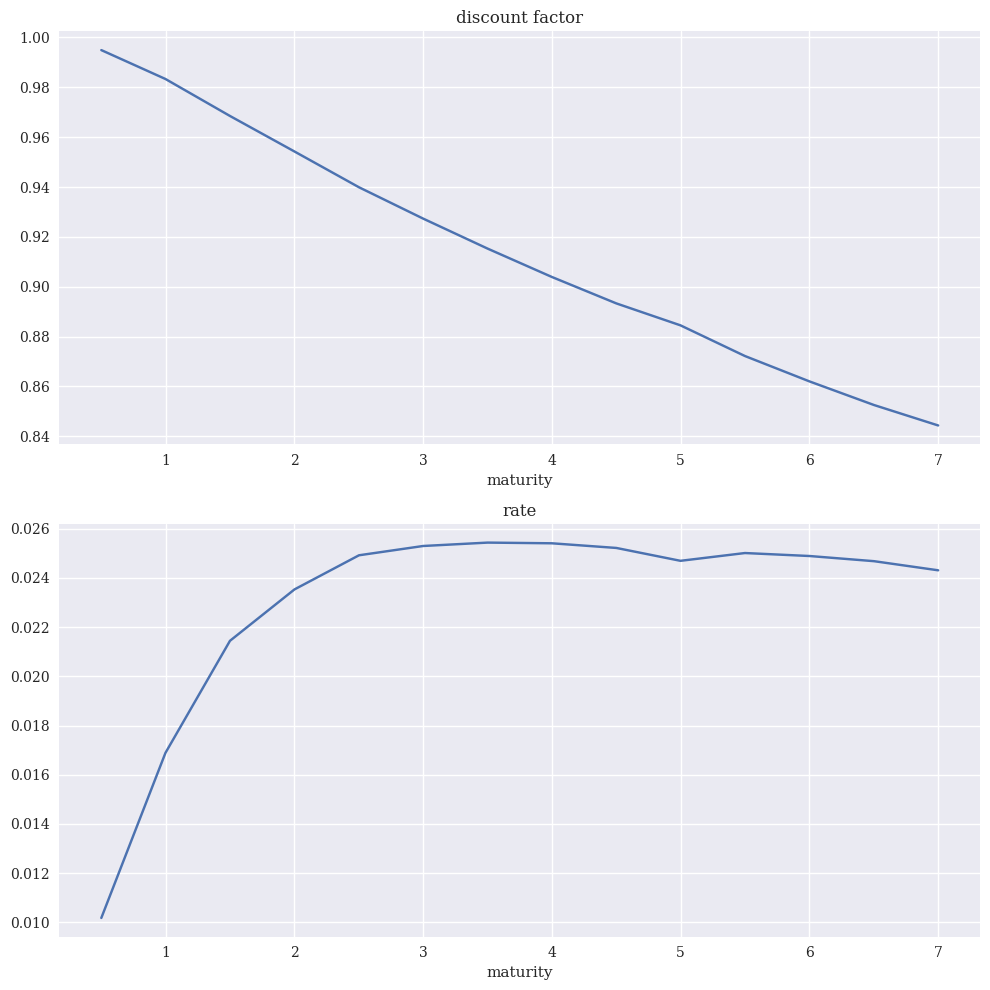

In [65]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
spot['Discount Factor'].plot(ax=ax[0],title='discount factor')
spot['Rate'].plot(ax=ax[1],title='rate')
plt.tight_layout()
plt.show()

In [74]:
forward_df1 = pd.DataFrame(spot['Discount Factor'].values/spot['Discount Factor'].shift().values, index = spot.index, columns=['discount factor'])
forward_df1['discount factor'].iloc[0] = spot['Discount Factor'].iloc[0]
forward_df1['rate'] = -np.log(forward_df1['discount factor']) / forward_df1.index.to_series().diff().mean()

In [75]:
forward_df1

,discount factor,rate
maturity,,
0.501027,0.994927,0.010172
0.999316,0.988348,0.023443
1.500342,0.984919,0.030394
2.001369,0.985287,0.029645
2.502396,0.984961,0.030308
3.000684,0.986630,0.026922
3.501711,0.987013,0.026146
4.000000,0.987593,0.024970
4.501027,0.988261,0.023618
